In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from typing import List, Tuple

# Recommended reading

Bayesian parameter estimation supersedes the t-test (Kruschke):

https://www.krigolsonteaching.com/uploads/4/3/8/4/43848243/kruschke2012jepg.pdf


Blog post on bayesian inference for parameter estimation:

https://towardsdatascience.com/probability-concepts-explained-bayesian-inference-for-parameter-estimation-90e8930e5348


Doing bayesian data analysis (Kruschke) - this is a text book but it's very easy to read:

https://www.amazon.com/Doing-Bayesian-Data-Analysis-Tutorial/dp/0124058884/ref=sr_1_2?gclid=Cj0KCQjwtr_mBRDeARIsALfBZA5eGMYTq2sXJYqDWP7tDLtVCZyQBTF3q2i5fxBKK3yLyXk1lxZ0yWAaAtmVEALw_wcB&hvadid=177324924950&hvdev=c&hvlocphy=1018127&hvnetw=g&hvpos=1t1&hvqmt=e&hvrand=6582771769838659026&hvtargid=kwd-28002132345&hydadcr=3208_9861567&keywords=doing+bayesian+data+analysis&qid=1557190781&s=gateway&sr=8-2


Information on conjugate priors (including a table to calculate posterior distributions for conjugate priors):

https://en.wikipedia.org/wiki/Conjugate_prior


Bayes theorem:

https://en.wikipedia.org/wiki/Bayes%27_theorem

## Some questions you may want to answer with data...
- How much is one group different from another? 
- Can we be sure that the difference between groups is non-zero?
- What is the magnitude of the difference and how certain are we about this magnitude?

### We need statistical methods to answer questions with data because data is noisy

### Bayesian analysis is more intuitive than traditional methods of null hypothesis testing

# A few notes on Bayesian inference 
- Bayesian inference is the reallocation of credibility across a space of candidate possibilities
- We realocate belief toward the parameter values that are consistent with the data, and away from parameter values are the inconsistent with the data
- Based on Bayes theorem - but we represent models of our data using distributions rather than single values
- We don't need p-values for bayesian inference!
- Bayesian methods can accept the null hypotheses (unlike traditional hypothesis testing methods)
- Decisions based on Bayesian analysis are better founded than traditional null hypothesis testing, whether or not the two methods agree
- Bayesian estimation does not require the assumption that the data are normally distributed
- The size of your data (N) and the "sharpness" of your prior impact the posterior (see page 112 - 115 in the kruschke book) 

# Some definitions:

### Bayes theorem for parameters:
P(paramter | data) = P(parameters) * P(data | parameters) / P(data)
we usually get rid of P(data) because it is just a normalizing constant to ensure our probability distribution sums to one, and it is almost always very difficult (or impossible) to calculate. If we toss out the normalizing constant P(data) bayest theorm becomes P(paramter | data) is proportional to P(parameters) * P(data | parameters) / P(data) 

You can think of it as -> Posterior = Prior distribution (prior beliefs) * Likelihood (data) 

### Prior distribution:
P(parameters) -> expresses our previous knowledge about parameter values, without including new data (but can include previously collected data or subject matter expertise / experience) - unless you have good reason to believe otherwise, usually make the prior distribution very broad and vague so that it doesn't overwhelm the posterior

### Likelihood: 
P(data | parameters) -> Essentially, this is a model (distribution) used to represent our data

### Posterior: 
This is the result of applying bayes theorem for models - our beliefs about the parameter values after we have multiplied the prior and the likelihood

### Conjugate Distribution
A special case that arises when the posterior distribution is from the same probability distribution family as the likelihood and the prior distributions. This is helpful because when you have conjugate distributions, it is possible to analytically determine the posterior distribution. Though sometimes it is still easier to use an approximation method such as markov chain montecarlo (mcmc) to determine the posterior. 

## Example 1:
We want to estimate the average height of women in WiMLDS Boston, using the women that are in this tutorial. Select a sensible prior and likelihood, then calculate the posterior distribution (if possible). If it is not possible to calculate the posterior distribution, discuss how you would go about approximating it. 

hint: https://www.usablestats.com/lessons/normal

In [2]:
mu_prior, sigma_prior = 65, 10 # This is our prior belief about the value of mu. 
# Usually we try to make the prior distrubution less certain (wider standard deviation) unless we are very certain
# in our prior beliefs. See page 112-115 in the Kruschke book. 

# Get the heights of everyone in the tutorial
data = [61, 70, 69, 59, 64, 57, 67]

Now we need to calculate or approximate the posterior distribution. Are our distributions conjugate? is there an equation we can use to calculate the posterior? Hint: https://en.wikipedia.org/wiki/Conjugate_prior

Is it ok to assume we know the standard deviation of the data? Sometime yes and sometimes no - when doing this in the "real world" we almost always discuss this and come to some sort of agreement depending on the situation. If at all possible we try not to make this assumption, and usually use markov chain montecarlo to approximate the posterior distribution. But, for the purposes of this tutorial this assumption will make calculating the posterior much easier (and mcmc is outside the scope of this tutorial). For now we will assume that the standard deviation is known and is equal to the standard deviation of the data. We can discuss why this is probably "ok" in our situation. But note that when you make this assumption, you can no longer calculate the posterior for standard deviation (unless you assume the mu is known and equal to the mu of your data). 

Note that the precision is 1 / variance - the equations are less ugly when we work with precision instead of standard deviation


Now let's make a function to calculate the posterior distribution:

In [3]:
def get_posterior(mu_prior: float, sigma_prior: float, data: List[float]) -> Tuple[float, float]:
    # In this case we will assume the variance of the data is the variance of the population
    mu_data = np.mean(data)
    precision_prior = 1 / sigma_prior ** 2 
    precision_data = 1 / np.std(data) **2
    n = len(data)
    term_1 = precision_prior * mu_prior / (n * precision_data + precision_prior)
    term_2 = precision_data * mu_data *  n / (n * precision_data + precision_prior)
    mu_posterior = term_1 + term_2
    precision_posterior = precision_prior + n * precision_data
    var_posterior = 1 / precision_posterior
    return mu_posterior, np.sqrt(var_posterior)

In [4]:
mu_posterior, sigma_posterior = get_posterior(sigma_prior=sigma_prior, mu_prior=mu_prior, data=data)
print(f"mu posterior = {mu_posterior:.2f}, sigma posterior: {sigma_posterior:.2f}")

mu posterior = 63.89, sigma posterior: 1.74


If the standard deviation of the posterior is small, it means we are quite certain that our mean is near the mu_posterior value. Conversely, if the standard deviation is large, it means that we are uncertain about the value of the mean. Also notice that as N increases, it overwhelms the prior distribution.

## Example 2
 Now imagine that you are working with a chemist to determine the potency, measured in micromolar (uM), of two compounds A and B in an assay, and then determine which compound is more potent. Potency in this assay can range from <1 uM (highly potent) to >1000 uM (not potent). You have taken 3 replicate measurements of compound A and compound B in the assay, which you can use to estimate the mean potency of each compound. You also have replicate measurements from a few standard compounds for which the true potency (20 uM) is known. You can use these replicates to estimate the assay variability. Though the range of potencies observed in this assay is between <1 and >1000 uM, the vast majority of compounds tested are between 25 and 400 uM (see Figure 1 below).  

First, let's plot all of the data from the assay to determine how the data are distributed.

In [5]:
all_data = np.random.lognormal(4, 1, 1000) # Make some example data

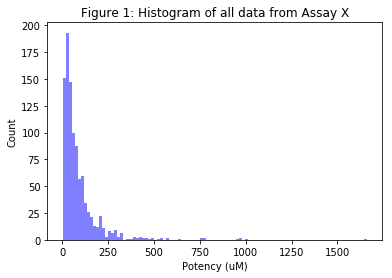

In [6]:
num_bins = 100
n, bins, patches = plt.hist(all_data, num_bins, facecolor='blue', alpha=0.5)
plt.title('Figure 1: Histogram of all data from Assay X')
plt.xlabel('Potency (uM)')
plt.ylabel('Count')
plt.show()

It looks like the data may be lognormally distributed... https://en.wikipedia.org/wiki/Log-normal_distribution
Let's try plotting the log of the data

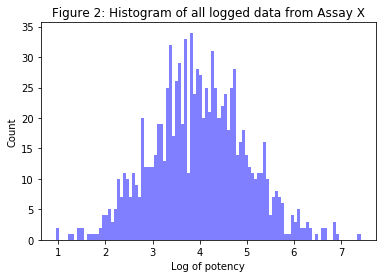

In [7]:
log_data = [math.log(a) for a in all_data]
num_bins = 100
n, bins, patches = plt.hist(log_data, num_bins, facecolor='blue', alpha=0.5)
plt.title('Figure 2: Histogram of all logged data from Assay X')
plt.xlabel('Log of potency')
plt.ylabel('Count')
plt.show()

Now let's try to quantify the noisiness of the assay. We will do this by calculating the standard deviation of replicates for the standard, compounds X, Y, Z, for which we have 100 measurements each. 

In [8]:
# Data for compound X (reference compound with known potency of 20 uM)
# Hint: random noise in data is typically normally distributed, even if your data is not normally distributed
cmpd_x_measurements = np.random.normal(20, 2.5, 100)
cmpd_y_measurements = np.random.normal(32, 2, 100)
cmpd_z_measurements = np.random.normal(10, 1.8, 100)

In [9]:
cmpd_x_std, cmpd_y_std, cmpd_z_std = np.std(cmpd_x_measurements), np.std(cmpd_y_measurements), np.std(cmpd_z_measurements)

In [10]:
assay_noise_std = np.mean([cmpd_x_std, cmpd_y_std, cmpd_z_std])

In [11]:
assay_noise_std

2.1574533997504557

Now we will assume that this is the standard deviation of the data and we can use this "known" standard deviation to estimate the potency of each compound based on the measurements we have collected. But first we will need to take the log of the standard deviation, since we are working in the log space. 

In [12]:
log_assay_noise_std = math.log(assay_noise_std)

In [13]:
actual_a_potency, actual_b_potency = 9, 12.5 # These values are unknown to us in real life 

In [14]:
cmpd_a_data = np.random.normal(actual_a_potency, assay_noise_std, 1)
cmpd_b_data = np.random.normal(actual_b_potency, assay_noise_std, 1)
cmpd_a_data, cmpd_b_data

(array([ 8.29820324]), array([ 13.40287196]))

In [15]:
log_a = [math.log(a) for a in cmpd_a_data]
log_b = [math.log(b) for b in cmpd_b_data]

Now we need to develop a reasonable posterior for the data... 

In [16]:
mu_prior, sigma_prior = 4, 10

Now lets plot our posterior to see if it seems reasonable

In [17]:
posterior_samples = np.random.normal(mu_prior, sigma_prior, 10000)

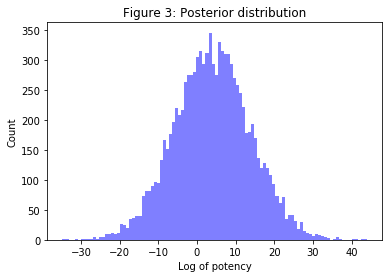

In [18]:
num_bins = 100
n, bins, patches = plt.hist(posterior_samples, num_bins, facecolor='blue', alpha=0.5)
plt.title('Figure 3: Posterior distribution')
plt.xlabel('Log of potency')
plt.ylabel('Count')
plt.show()

Now let's calculate the posterior distribution:

In [19]:
def get_posterior_known_var(mu_prior: float, sigma_prior: float, data: List[float], data_sigma: float) -> Tuple[float, float]:
    # Now we will use the variance we previously calculated 
    mu_data = np.mean(data)
    precision_prior = 1 / sigma_prior ** 2 
    precision_data = 1 / data_sigma **2
    n = len(data)
    term_1 = precision_prior * mu_prior / (n * precision_data + precision_prior)
    term_2 = precision_data * mu_data *  n / (n * precision_data + precision_prior)
    mu_posterior = term_1 + term_2
    precision_posterior = precision_prior + n * precision_data
    var_posterior = 1 / precision_posterior
    return mu_posterior, np.sqrt(var_posterior)

In [20]:
mu_a, sigma_a = get_posterior_known_var(mu_prior=mu_prior, sigma_prior=sigma_prior, data=log_a, data_sigma=log_assay_noise_std)
mu_b, sigma_b = get_posterior_known_var(mu_prior=mu_prior, sigma_prior=sigma_prior, data=log_b, data_sigma=log_assay_noise_std)
print(f"mu a = {mu_a}, sigma_a = {sigma_a}")
print(f"mu_b = {mu_b}, sigma_b= {sigma_b}")

mu a = 2.1271124826863823, sigma_a = 0.7666654258946338
mu_b = 2.6037245038237566, sigma_b= 0.7666654258946338


In [21]:
mu_a_potency = math.exp(mu_a)
mu_b_potency = math.exp(mu_b)
print(f"potency estimate of compound a = {mu_a_potency:.2f} uM")
print(f"potency estimate of compound b = {mu_b_potency:.2f} uM ")

potency estimate of compound a = 8.39 uM
potency estimate of compound b = 13.51 uM 


Is compound a more potent than compound b? Let's start creating the distribution of means for each compound:

In [22]:
dist_a = np.random.normal(mu_a, sigma_a, 1000)
dist_b = np.random.normal(mu_b, sigma_b, 1000)

In [23]:
diff = dist_a - dist_b
frac_a_less_than_b = sum(diff < 0) / len(diff)
print(f"There is a {frac_a_less_than_b*100:.2f}% chance that a is more potent than b")

There is a 64.50% chance that a is more potent than b


Usually we say if >95% the the samples pulled from the distributions of a are less than b, a is more potent than b. (note: you don't have to use 95%, this is up to your discretion, but usually we use 95% to determine statistical significance) 

Now let's see what happens if we add some more data...

In [25]:
cmpd_a_data = np.random.normal(actual_a_potency, assay_noise_std, 20)
cmpd_b_data = np.random.normal(actual_b_potency, assay_noise_std, 20)
log_a = [math.log(a) for a in cmpd_a_data]
log_b = [math.log(b) for b in cmpd_b_data]

In [26]:
mu_a, sigma_a = get_posterior_known_var(mu_prior=mu_prior, sigma_prior=sigma_prior, data=log_a, data_sigma=log_assay_noise_std)
mu_b, sigma_b = get_posterior_known_var(mu_prior=mu_prior, sigma_prior=sigma_prior, data=log_b, data_sigma=log_assay_noise_std)
print(f"mu a = {mu_a}, sigma_a = {sigma_a}")
print(f"mu_b = {mu_b}, sigma_b= {sigma_b}")

mu a = 2.15987125117229, sigma_a = 0.1719122405982842
mu_b = 2.588143367088603, sigma_b= 0.1719122405982842


In [27]:
mu_a_potency = math.exp(mu_a)
mu_b_potency = math.exp(mu_b)
print(f"potency estimate of cmpd a = {mu_a_potency:.2f} uM")
print(f"potency estimate of compound b = {mu_b_potency:.2f} uM")

potency estimate of cmpd a = 8.67 uM
potency estimate of compound b = 13.31 uM


Let's plot our potency estimates for the two compounds, and compare their distributions

In [28]:
dist_a = np.random.normal(mu_a, sigma_a, 1000)
dist_b = np.random.normal(mu_b, sigma_b, 1000)

In [29]:
diff = dist_a - dist_b
frac_a_less_than_b = sum(diff < 0) / len(diff)
print(f"There is a {frac_a_less_than_b*100:.2f}% chance that a is more potent than b")

There is a 96.10% chance that a is more potent than b


Now we can say that compound a is more potent than compound b. 